<a href="https://colab.research.google.com/github/abirmondal/detect-abusive-comment/blob/main/test/banglabert_test_17_11_abir_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Code of BanglaBERT Implementation

# Import Necessary Libraries

In [ ]:
%%capture
!pip install transformers

In [ ]:
# Uncomment the below code if the notebook is run on Google Colab.

!git clone https://github.com/abirmondal/detect-abusive-comment.git

Cloning into 'detect-abusive-comment'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 141 (delta 19), reused 1 (delta 1), pack-reused 97
Receiving objects: 100% (141/141), 37.36 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [ ]:
import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForPreTraining

In [ ]:
utils_folder_path = '/content/detect-abusive-comment/src/utils'

import os
os.chdir(utils_folder_path)
import dataset as ds
import model_report as mr

# Load Dataset

In [ ]:
df_test_org = ds.get_test_set()

In [ ]:
class TextDatasetWrapper(Dataset):
    def __init__(self, df, text_col='text', label_col='hate'):
        self.df = df
        self.__text_col__ = text_col
        self.__label_col__ = label_col
    def __getitem__(self, index):
        text = self.df[self.__text_col__][index]
        label = self.df[self.__label_col__][index]
        return text, label
    def __len__(self):
        return len(self.df)

In [ ]:
df_test = TextDatasetWrapper(df_test_org)

In [ ]:
batch_size=128
df_test_batches = DataLoader(df_test, batch_size=batch_size, shuffle=False)

# Load Tokenizer and BanglaBERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert")
model.to(device)

(…)abert/resolve/main/tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

(…)tnlp/banglabert/resolve/main/config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

(…)uetnlp/banglabert/resolve/main/vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

(…)ert/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

ElectraForPreTraining(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

# Genarate Embeddings

In [ ]:
def text_to_embedding_batches(df_batches):
    df_embeddings = []
    with torch.no_grad():
        for batch in tqdm(df_batches, desc='Genarating Embeddings'):
            tokenized_texts = tokenizer(batch[0], return_tensors="pt", padding='max_length', max_length=256, truncation=True)
            tokenized_texts = tokenized_texts.to(device)
            embedding_texts = model(**tokenized_texts)['logits']
            df_embeddings.append(embedding_texts)
            del tokenized_texts
            del embedding_texts
            torch.cuda.empty_cache()
    df_embeddings = torch.cat(df_embeddings, dim=0)
    return df_embeddings

In [ ]:
df_test_embeddings = text_to_embedding_batches(df_test_batches)

Genarating Embeddings:   0%|          | 0/142 [00:00<?, ?it/s]

In [ ]:
X_test = tf.convert_to_tensor(df_test_embeddings.to('cpu'), dtype=tf.float32)
y_test = df_test_org['hate']

# Load Pre-trained Model

In [ ]:
binary_classification_model_path = '/content/detect-abusive-comment/src/models/m_data_21_9_banglabert_100_4_77_77.keras'

binary_classification_model = tf.keras.models.load_model(binary_classification_model_path)

# Prediction of test set from Model

In [ ]:
with tf.device(tf.config.experimental.list_physical_devices('GPU')[0].device_type):
    y_test_pred = binary_classification_model.predict(X_test)

565/565 [==============================] - 9s 12ms/step


# Threshold Labelling

In [ ]:
binary_threshold = 0.4
def pred_of_y_labelling(y):
    return (1 if y[0] > binary_threshold else 0)

y_pred = np.apply_along_axis(pred_of_y_labelling, 1, y_test_pred)

In [ ]:
mr.model_eval(y_pred, y_test)

    Accuracy Score:  0.7689966240522442
Weighted Precision:  0.7671930053503849
   Weighted Recall:  0.7109686781956706
          F1-Score:  0.7380115490836053

Classification Report :-
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      9800
           1       0.77      0.71      0.74      8269

    accuracy                           0.77     18069
   macro avg       0.77      0.76      0.77     18069
weighted avg       0.77      0.77      0.77     18069



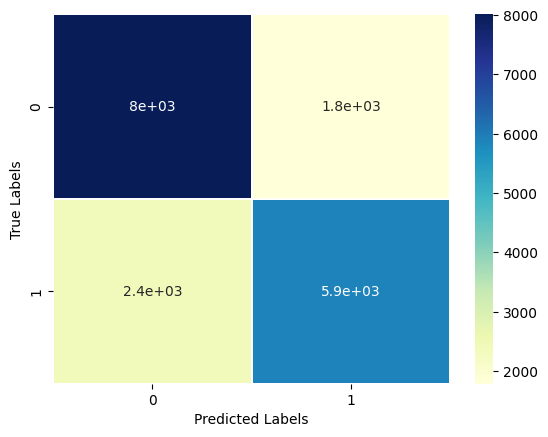

In [ ]:
mr.confusion_mat(y_pred, y_test)